In [2]:
import finesse
from finesse.components.mechanical import SuspensionZPK
from finesse.analysis.actions import RunLocks, Xaxis, Noxaxis, Change
import matplotlib.pyplot as plt
import numpy as np

finesse.configure(plotting=True)

In [190]:
base = finesse.Model()
base.parse(
"""
# Add a Laser named L0 with a power of 1 W.
l L0 P=1

s s1 portA=L0.p1 portB=eo1.p1
mod eo1 15M 0.3 order=1
s s2 portA=eo1.p2 portB=Min.p1

# The cavity
m Min R=0.9937 L=0
s scav Min.p2 Mend.p1 L=1
m Mend R=1 L=0 phi=0 

# Suspend mirrors on pendula
#pendulum sus1 Min.mech mass=0.25 fz=1 Qz=1000
pendulum sus2 Mend.mech mass=0.25 fz=1 Qz=1000

# Power detectors on reflection, circulation and transmission.
pd refl Min.p1.o
pd circ Mend.p1.i
pd trns Mend.p2.o

"""
)

In [191]:
force = np.random.random(970)
kat_base = base.deepcopy()

kat_base.parse(f"""
fsig(1)
sgen force Mend.mech.F_z amplitude=1 phase=0

xd Mend_z Mend.mech.z
xd Min_z Min.mech.z

sweep(force.amplitude, {list(force)}, False,) 
""")

out_base = kat_base.run()

In [213]:
kat = base.deepcopy()

kat.parse(f"""
fsig(1)
sgen force Mend.mech.F_z amplitude=1 phase=0

readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True
zpk ZPK_symbol [10*2*pi] [2*pi] gain=-100M  #-100M
link(rd_refl.I, ZPK_symbol)
ad symbol_gain ZPK_symbol.p2.o f=&fsig

wire wire ZPK_symbol.p2.o Mend.mech.F_z

xd Mend_z Mend.mech.z
xd Min_z Min.mech.z

sweep(force.amplitude, {list(force)}, False,) 
#xaxis(fsig.f, log, 0.1, 100, 300)
#xaxis(force.amplitude, lin, 0.1, 10, 300)
""")

out = kat.run()
# out.plot("symbol_gain");

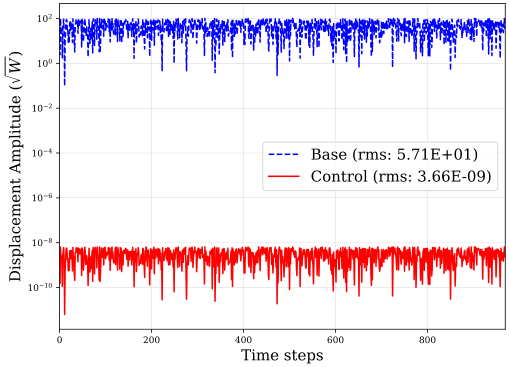

In [214]:
# xs, ys = zip(*sorted(zip(force, np.abs(out["Mend_z"]))))

fig, ax =plt.subplots(figsize=(8,6))

control = np.abs(out["Mend_z"])
basecase = np.abs(out_base["Mend_z"])
ax.semilogy(basecase, '--', label=f"Base (rms: {np.sqrt(np.mean(basecase**2)):.2E})")
ax.semilogy(control, label=f"Control (rms: {np.sqrt(np.mean(control**2)):.2E})")

# ax.semilogy(np.abs(out["Min_z"]), '--', label="control ITM")
# ax.semilogy(np.abs(out_base["Min_z"]), '--', label="base ITM")

ax.legend(loc="best", fontsize=15)
ax.set_xlabel("Time steps", fontsize=15)
ax.set_ylabel(r"Displacement Amplitude ($\sqrt{W}$)", fontsize=15);

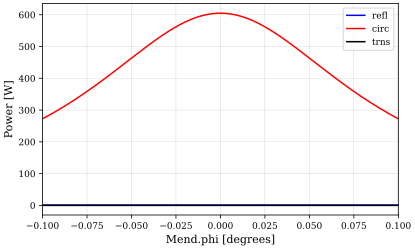

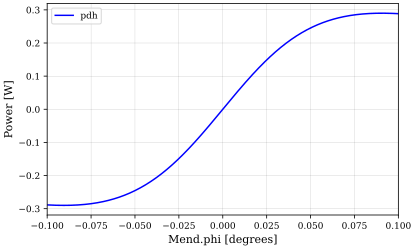

The (rough) tuning for HG33 resonance is 0.0...
The (rough) slope for the error signal is 64.0663595893648,  and the gain should be -0.015608815709360251


In [208]:
#
kattest = base.deepcopy()

kattest.parse("""
xaxis(Mend.phi, lin, -0.1, 0.1, 400)
power_detector_demod_1 pdh node=Min.p1.o f=&eo1.f phase=-179.44317522587946
""")

o = kattest.run()
o.plot('refl', 'circ', 'trns', 'pdh')

tuning = -0.01 + (0.02)/400*np.argmax(o['circ'])
print(f"The (rough) tuning for HG33 resonance is {tuning}...")
slope = (o['pdh'][np.argmax(o['circ'])+1] - o['pdh'][np.argmax(o['circ'])-1])/((0.02)/200)
print(f"The (rough) slope for the error signal is {slope},  and the gain should be {-1/slope}")

-179.44319385361067


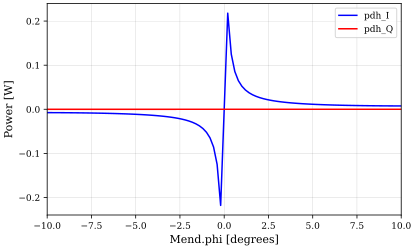

In [209]:
model = base.deepcopy()

for el in model.elements:
    if el.startswith('pdh'):
        model.remove(el)

eps = 1e-9
model.parse(f"""
xaxis(Mend.phi, lin, -{eps/2}, {eps/2}, 1, relative=True)
power_detector_demod_1 pdh_complex node=Min.p1.o f=&eo1.f    
""")
sol = model.run()

opt_demod = np.angle(
    np.gradient(
        sol['pdh_complex'], eps
    ).mean(),
    deg=True 
)
print(opt_demod)

model.parse(f"""
pd1 pdh_I Min.p1.o f=&eo1.f phase={opt_demod}
pd1 pdh_Q Min.p1.o f=&eo1.f phase={opt_demod+90}
xaxis(Mend.phi, lin, -10, 10, 100)
""")
sol = model.run()
sol.plot('pdh_I', 'pdh_Q');

In [210]:
katbase = base.deepcopy()
katbase.parse("""
power_detector_demod_1 pdh node=Min.p1.o f=&eo1.f phase=-179.44317522587946
lock lock_length pdh Mend.phi -0.15608344329215287 1e-9
""")
out = katbase.run(Noxaxis(pre_step=RunLocks()))
out["circ"]

604.9150618060303

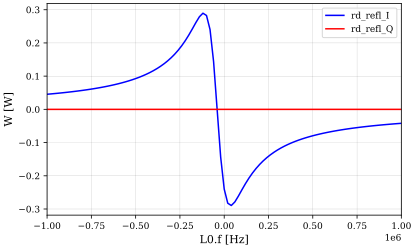

In [6]:
kat = base.deepcopy()

kat.parse("""
readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True
xaxis(L0.f, lin, -1M, 1M, 100)
""")

out = kat.run()
out.plot("rd_refl_I", "rd_refl_Q");

In [7]:
kat.rd_refl.nodes

OrderedDict([('Min.p1.o', <OpticalNode Min.p1.o @ 0x156e85a00>),
             ('Min.p1.i', <OpticalNode Min.p1.i @ 0x156e85940>),
             ('rd_refl.I.o', <SignalNode rd_refl.I.o @ 0x156e94b50>),
             ('rd_refl.Q.o', <SignalNode rd_refl.Q.o @ 0x156e94910>)])

<Figure size 576x355.968 with 0 Axes>

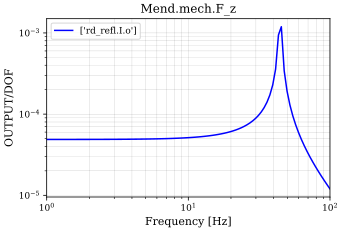

In [8]:
model = base.deepcopy()

model.parse("""
readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True

fsig(1)
frequency_response(
geomspace(1, 100, 100),
#L0.amp,
Mend.mech.F_z, 
rd_refl.I.o,)
""")

out = model.run()
out.plot();

In [9]:
force = np.random.random(100)
force[:10]

array([0.11570876, 0.26835452, 0.17095574, 0.92752542, 0.43628811,
       0.47623223, 0.0904792 , 0.94019118, 0.66362642, 0.83777269])

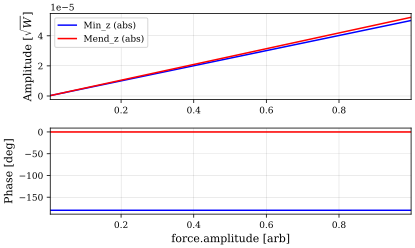

In [10]:
kat = base.deepcopy()

kat.parse(f"""
fsig(1)
variable ETMForceAmp 1
sgen force Mend.mech.F_z amplitude=ETMForceAmp phase=0

variable a 20*2*pi
readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True
zpk ZPK_symbol [] [-1j*&a, 1j*&a] gain=-1
link(rd_refl.I, ZPK_symbol)
ad symbol_gain ZPK_symbol.p2.o f=&fsig

variable ITMForceAmp force.amplitude
sgen ITMforce Min.mech.F_z amplitude=ITMForceAmp phase=180
link(ZPK_symbol.p2.o, ITMforce.amplitude)

xd Mend_z Mend.mech.z
xd Min_z Min.mech.z

variable index 1
sweep(force.amplitude, {list(force)}, False, 
    pre_step=series(
    #print_model_attr(force.amplitude),
    change(ITMforce.amplitude=force.amplitude),
    #print_model_attr(ITMforce.amplitude),
    )
)
#xaxis(ETMForceAmp, lin, 0.1, 10, 300)
#xaxis(force.amplitude, lin, 0.1, 1, 300)

""")

out = kat.run()
#print(out.x)
out.plot("Min_z", "Mend_z");

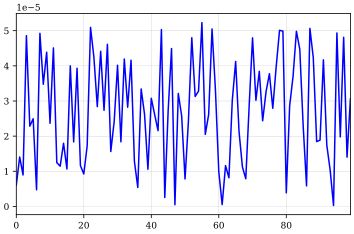

In [11]:
plt.plot(abs(out['Mend_z']));

In [12]:
kat.symbol_gain

<'symbol_gain' @ 0x156f42df0 (AmplitudeDetector)>

In [4]:
finesse.help("wires")

str object
'wires'

str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.

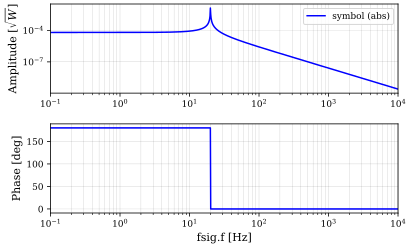

In [14]:
model = finesse.Model()
model.parse("""
# Finesse always expects some optics to be present
# so we make a laser incident on some photodiode
l l1 P=1
readout_dc PD l1.p1.o #output_detectors=True
# Amplitude modulate a laser
sgen sig l1.amp

# Using symbolics
variable a 20*2*pi
zpk ZPK_symbol [] [-1j*&a, 1j*&a] -1
link(PD.DC, ZPK_symbol)
ad symbol ZPK_symbol.p2.o f=&fsig

fsig(1)
xaxis(fsig, log, 0.1, 10k, 1000)
""")

sol = model.run()
sol.plot(log=True);